# Dataproject on life expectancy

Ting vi mangler:
-  Få fikset aksen på kort (Elin)
-  Vil vi ikke gerne have lifeexp65 med i widget drop down figuren?

Imports and set magics:

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import plotly.graph_objects as go
import ipywidgets as widgets

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


In [ ]:
pip install geopandas

In [ ]:
pip install linearmodels

# Our data 

In this data project we will investigate how daily smoking, social support and alcohol consumption affects life expectancy at age 65 years old. The explanatory variabels are chosen based on an expected effect. All data are taken from the OECD database (https://data.oecd.org) and are imported as csv-files. All datasets contain observations in the interval from 1960 to 2021. We import at the following datasets:

-  **lifeexp65.csv:** Life expectancy at 65 is measured as the average number of years that a person at 65 years can be expected to live assuming that age-specifikc mortality levels remain constant. The dataset contains observations for men and women individually. We also import the two datasets *men_lifeexp65.csv* and *women_lifeexp65.csv* which contain *lifeexp65* data for men and women respectively in 2020. 

-  **alcohol.csv:** Alchol consumption is defined as annual sales of pure alcohol in litres per person aged 15 years and older. The dataset contains obervations for the entire population.

-  **smokers.csv:** Daily smokers are defined as the population aged 15 years and older who are reporting to smoke every day. The indicator is measured as a percentage of the population aged 15 years and older and is stated for men, women and the total population.

-  **socsupport.csv:** Social support indicates the share of people who report having friends or relatives whom they can count on in times of trouble. The indicator is measures as a percentage of survey respondent. Due to small sample sizes, country averages are pooled between 2010 and 2020. The survey sample is designed to be nationally representative of the population ages 15 years and older. 

To give an overview of the current lifeexpectancy on a global plan we present *lifeext65* in two maps showing life expectancy at 65 for men and women respectively, in 2020 for data in our dataset. 

To give an overview of the current lifeexpectancy on a global plan we make the two maps below. These maps show life expectancy at 65 for men and women in 2000 for data in our data set. 

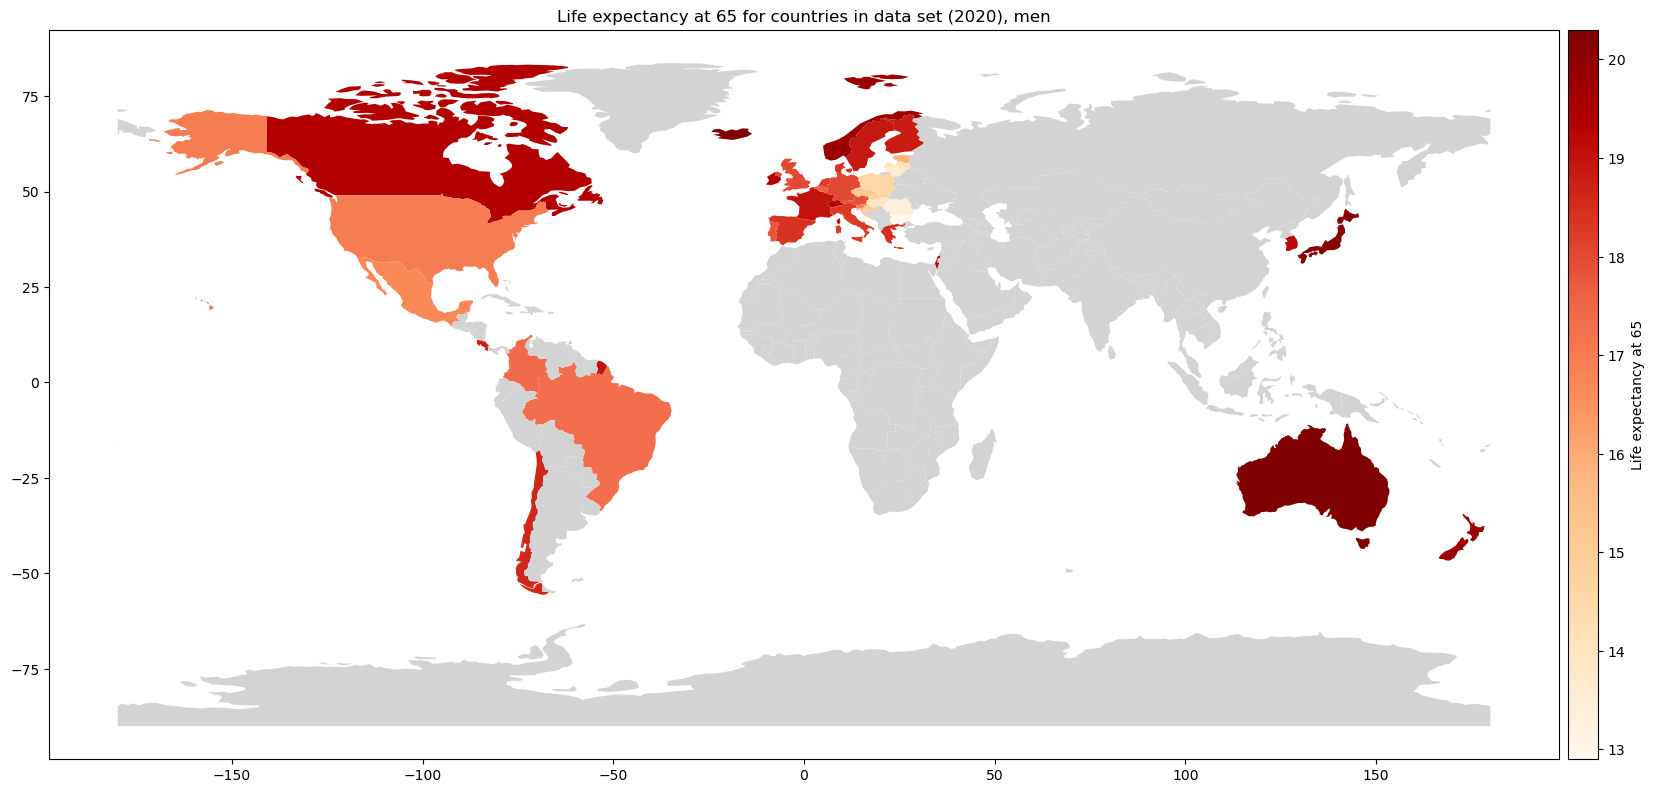

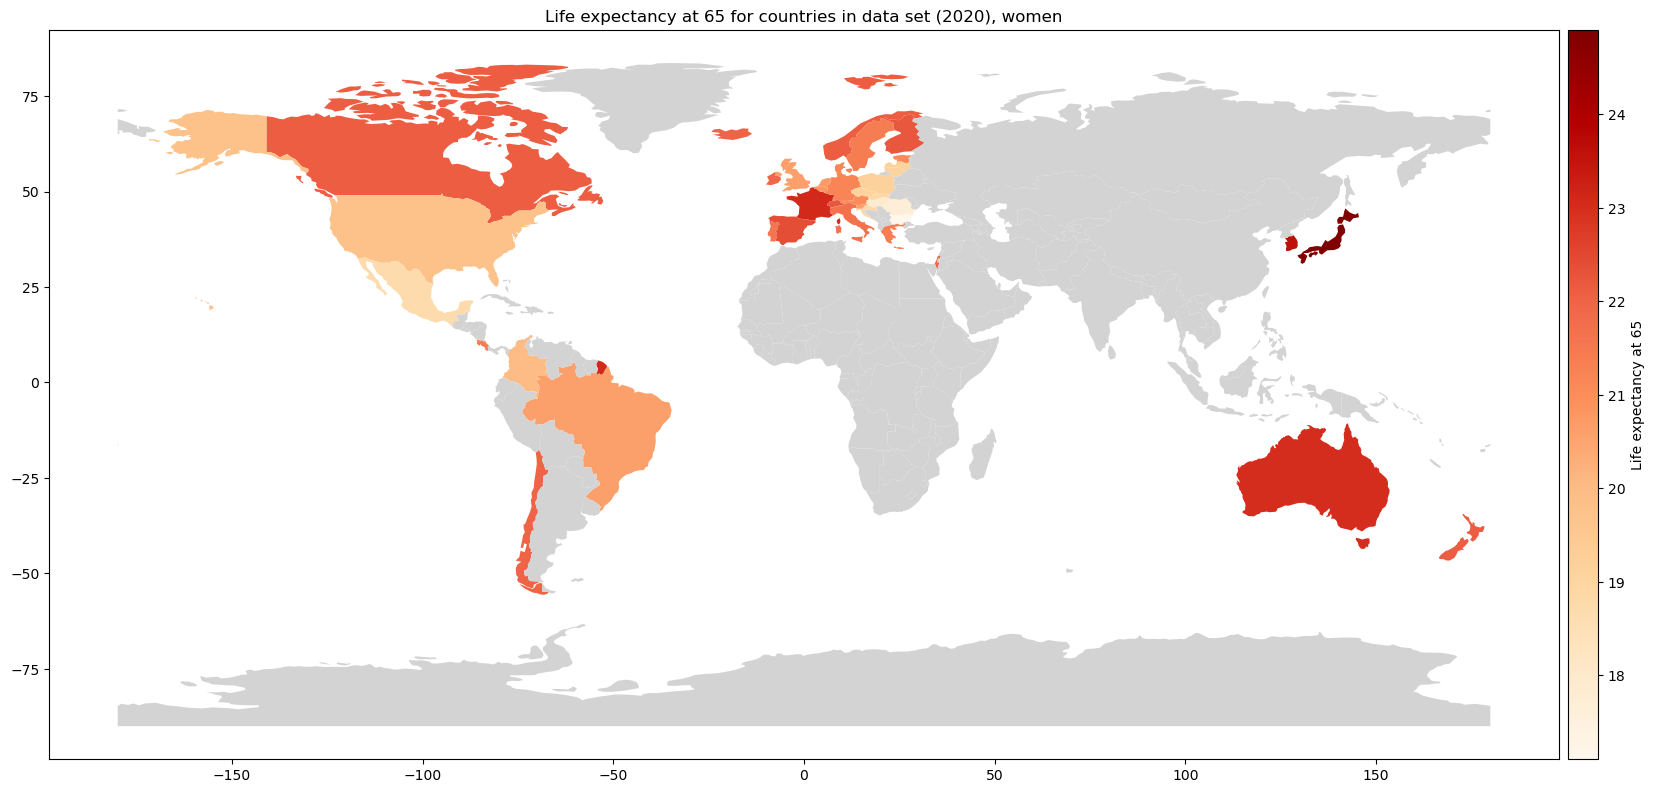

In [2]:
# making overview map for countries in data set

for data in ['men_lifeexp65.csv', 'women_lifeexp65.csv']:
    # rewrite to use in titles in final plot
    data_title = data.rstrip('_lifeexp65.csv')
    # load and clean data
    mapdata = pd.read_csv(data)
    drop = ['INDICATOR','SUBJECT','MEASURE','FREQUENCY','TIME','Flag Codes']
    mapdata.drop(drop, axis=1, inplace=True)

    # load data to make world map
    df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # merge map data to world map
    df_world_mapdata = df_world.merge(mapdata, how="left", left_on=['iso_a3'], right_on=['LOCATION'])

    # add visuals, axes, labels and title
    fig, ax = plt.subplots(1, 1, figsize=(20, 16))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad="0.5%")
    df_world_mapdata.plot(column="Value", ax=ax, cax=cax, cmap='OrRd',legend=True, legend_kwds={"label": "Life expectancy at 65"}, missing_kwds={'color':'lightgrey'})
    ax.set_title(f'Life expectancy at 65 for countries in data set (2020), {data_title}')


# Read and clean data

In [3]:
# importing data
alcohol = pd.read_csv('alcohol.csv')
life_exp_65 = pd.read_csv('lifeexp65.csv')
smokers = pd.read_csv('smokers.csv')
social_support = pd.read_csv('socsupport.csv')

In [4]:
# clean alcohol data
drop = ['INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes']
alcohol.drop(drop, axis=1, inplace=True)

alcohol.rename(columns={'LOCATION':'country', 'TIME':'year', 'Value':'alcohol_sale'}, inplace=True)

# clean life_exp_65 data
drop = ['INDICATOR','MEASURE','FREQUENCY','Flag Codes']
life_exp_65.drop(drop, axis=1, inplace=True)

life_exp_65.rename(columns={'LOCATION':'country', 'SUBJECT':'sex','TIME':'year', 'Value':'exp_years'}, inplace=True)

life_exp_65_wide = pd.pivot_table(life_exp_65,index='country',columns='year',values='exp_years')

# clean smokers data
I = smokers.SUBJECT.str.contains('WOMEN')
I |= smokers.SUBJECT.str.contains('MEN')
smokers.loc[I,:]
smokers = smokers.loc[I == False]

drop = ['INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes']
smokers.drop(drop, axis=1, inplace=True)

smokers.rename(columns={'LOCATION':'country', 'TIME':'year', 'Value':'smoking'}, inplace=True)

# clean social_support data
I = social_support.SUBJECT.str.contains('TOT')
social_support.loc[I,:]
social_support = social_support.loc[I == True]

drop = ['INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes']
social_support.drop(drop, axis=1, inplace=True)

social_support.rename(columns={'LOCATION':'country', 'TIME':'year', 'Value':'share_support'}, inplace=True)

In [ ]:
### Det her er de enkelte figurer og noget (i toppen) som jeg ikke helt ved hvad er, og ikke tror vi skal bruge

alcohol_wide = pd.pivot(alcohol,index='country',columns='year',values='alcohol_sale')

col_dict = {}
for i in range(1960,2022):
    col_dict[str(i)] = f'alc{i}'

col_dict = {str(i) : f'alc{i}' for i in range(1960,2022)}

alcohol_wide.rename(columns =col_dict, inplace=True)

#drop_list=[*range(1960,2000)]
#drop_list.append(2021)

#alcohol_wide.drop(drop_list, axis=1, inplace=True)

# figure (alcohol)
def plot(df, country):
    I=df['country']==country
    ax=df.loc[I,:].plot(x='year', y='alcohol_sale', legend=False)

widgets.interact(plot, 
    df = widgets.fixed(alcohol),
    country = widgets.Dropdown(description='country', 
                                    options=alcohol.country.unique(), 
                                    value='AUS')
);

# figure (life_exp_65)
def plot(df, country):
    I=df['country']==country
    ax=df.loc[I,:].plot(x='year', y='exp_years', legend=False)

widgets.interact(plot, 
    df = widgets.fixed(life_exp_65_wide),
    country = widgets.Dropdown(description='country', 
                                    options=life_exp_65_wide.country.unique(), 
                                    value='AUS')
);

#life_exp_65_long = pd.melt(life_exp_65_wide, id_vars='country',value_vars='year')

# figure (overobese)
def plot(df, country):
    I=df['country']==country
    ax=df.loc[I,:].plot(x='year', y='share_obese', legend=False)

widgets.interact(plot, 
    df = widgets.fixed(overobese),
    country = widgets.Dropdown(description='country', 
                                    options=overobese.country.unique(), 
                                    value='AUS')
);

# figure (smokers)
def plot(df, country):
    I=df['country']==country
    ax=df.loc[I,:].plot(x='year', y='smoking', legend=False)

widgets.interact(plot, 
    df = widgets.fixed(smokers),
    country = widgets.Dropdown(description='country', 
                                    options=smokers.country.unique(), 
                                    value='AUS')
);

# figure (social_support)
def plot(df, country):
    I=df['country']==country
    ax=df.loc[I,:].plot(x='year', y='share_support', legend=False)

widgets.interact(plot, 
    df = widgets.fixed(social_support),
    country = widgets.Dropdown(description='country', 
                                    options=social_support.country.unique(), 
                                    value='AUS')
);

## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

In [5]:
def plot_func():
    # Function that operates on data set
    pass

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
); 


interactive(children=(Output(),), _dom_classes=('widget-interact',))

Explain what you see when moving elements of the interactive plot around. 

# Merge data sets

In [6]:
df1 = life_exp_65_wide.stack().reset_index()
df1.rename(columns={'0':'Average'},inplace=True)

In [15]:
#merging the data
smokeralc = pd.merge(smokers,alcohol,on=['country','year'],how='left')
smokalcsoc = pd.merge(smokeralc, social_support,on=['country','year'],how='left')
merged = pd.merge(df1, smokalcsoc ,on=['country','year'],how='left')

merged.rename(columns = {'0':'life_exp'},inplace=True)
merged.set_index(['country','year'])
merged.loc[merged.country == 'USA']
merged.head(20)

,country,year,0,smoking,alcohol_sale,share_support
0,AUS,1960,14.05,NaN,NaN,NaN
1,AUS,1961,14.15,NaN,NaN,NaN
2,AUS,1962,14.00,NaN,NaN,NaN
3,AUS,1963,14.05,NaN,NaN,NaN
4,AUS,1964,13.75,43.0,10.1,NaN
5,AUS,1965,13.95,NaN,NaN,NaN
6,AUS,1966,13.75,40.0,10.3,NaN
7,AUS,1967,14.05,NaN,NaN,NaN
8,AUS,1968,13.75,NaN,NaN,NaN
9,AUS,1969,14.05,37.0,11.6,NaN


CODE TIL FÆLLES WIDGET

In [16]:
def plot(df, country, var):
    I=df['country']== country
    ax=df.loc[I,:].plot(x='year', y=str(var), legend=False) 
    
def plot_timeseries(df):
    widgets.interact(plot, 
    df = widgets.fixed(df),
    var = widgets.Dropdown(
        description='variable', 
        options=['smoking','alcohol_sale','share_support'], 
        value='smoking'),
    country = widgets.Dropdown(
        description='country', 
        options=df.country.value_counts().index.to_list(), 
        value='AUS')          
);

In [17]:
plot_timeseries(merged)

interactive(children=(Dropdown(description='country', index=17, options=('NOR', 'POL', 'FRA', 'AUT', 'EST', 'N…

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

Vi laver inner merged til vores regression - kun år hvor hvert land har alle værdier

In [18]:
#merging the data for regression
smokeralcregress = pd.merge(smokers,alcohol,on=['country','year'],how='inner')
smokalcsocregress = pd.merge(smokeralcregress, social_support,on=['country','year'],how='inner')
mergedregress = pd.merge(df1, smokalcsocregress ,on=['country','year'],how='inner')
mergedregress.head(20)
mergedregress.rename(columns={0:'life_exp'},inplace=True)
mergedregress.head(20)

,country,year,life_exp,smoking,alcohol_sale,share_support
0,AUS,2007,20.05,16.9,10.8,95.700469
1,AUS,2010,20.35,15.3,10.4,95.353709
2,AUS,2013,20.65,13.0,9.9,92.723545
3,AUS,2016,20.95,12.4,9.5,93.608335
4,AUT,2006,19.00,23.2,12.5,91.604918
5,AUT,2014,20.15,24.3,12.2,89.394312
6,AUT,2019,20.20,20.6,11.6,95.564168
7,BEL,2008,19.10,20.5,10.5,91.906487
8,BEL,2013,19.60,18.9,10.3,90.624392
9,BEL,2018,20.25,15.4,9.2,92.107227


In [19]:
index = pd.MultiIndex.from_frame(mergedregress[['country', 'year']])

regression = pd.DataFrame(mergedregress[mergedregress.columns.to_list()[2:]].values ,index=index, columns=['y','x1','x2','x3'])

from linearmodels.panel import PanelOLS

mod = PanelOLS.from_formula("y ~ 1 + x1 + x2 + x3 + EntityEffects + TimeEffects", data=regression)

res = mod.fit(cov_type='clustered', cluster_entity=True)

print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                      y   R-squared:                        0.0682
Estimator:                   PanelOLS   R-squared (Between):              0.0594
No. Observations:                 311   R-squared (Within):               0.1078
Date:                Sun, Apr 09 2023   R-squared (Overall):              0.0666
Time:                        14:31:15   Log-likelihood                   -56.604
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.1734
Entities:                          40   P-value                           0.0005
Avg Obs:                       7.7750   Distribution:                   F(3,253)
Min Obs:                       2.0000                                           
Max Obs:                       16.000   F-statistic (robust):             2.2990
                            

In [20]:
res.params

Intercept    17.710578
x1           -0.003923
x2           -0.082405
x3            0.027719
Name: parameter, dtype: float64

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.